In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import minimize_scalar

np.random.seed(0)

## Generate data, Estimators

In [3]:
# params
p = 200
c1 = 90
c2 = 30
n1 = c1 * p
n2 = c2 * p
sigma = 5.0

# covariates
X1 = np.random.randn(n1, p)
X2 = np.random.randn(n2, p)

# models
beta_t = np.random.randn(p, 1)

# labels
Y2 = X2 @ beta_t + sigma * np.random.randn(n2, 1)
hat_beta_t = np.linalg.inv(X2.T @ X2) @ X2.T @ Y2

def te_target(X1, X2, beta_s, beta_t, w, sigma_2 = sigma, Sigma2_sqrt = np.eye(p)):
    K = np.linalg.inv(w**2 * X1.T @ X1 + X2.T @ X2)
    beta_diff = beta_s - w * beta_t
    
    var = sigma_2**2 * np.trace(K @ Sigma2_sqrt @ Sigma2_sqrt)
    model_shift_bias = w**2 * np.linalg.norm(Sigma2_sqrt @ K @ X1.T @ X1 @ beta_diff) **2
    return model_shift_bias + var

def mtl_target(X1, X2, beta_s, beta_t, w, n1, n2, Sigma_1_sqrt = np.eye(p), Sigma_2_sqrt = np.eye(p)):
    K = np.linalg.inv(w**2 * X1.T @ X1 + X2.T @ X2)
    beta_diff = beta_s - w * beta_t
    
    var = sigma**2 * (n1 + n2) * np.trace(K)
    model_shift_bias = n1 * (np.linalg.norm(K @ X2.T @ X2 @ beta_diff) ** 2)
    model_shift_bias += n2 * w**2 * (np.linalg.norm(K @ X1.T @ X1 @ beta_diff) ** 2)
    return (model_shift_bias + var) / (n1 + n2)

## Find optimal w

In [4]:
def opt_w_val(X1, X2, beta_s, beta_t, n1, n2, c = 1, lb = 0.0, ub = 5.0, num = 10):
    def f_val(w):
        return mtl_target(X1, X2, beta_s, beta_t, w, n1, n2)
    
    gap = ub / num
    x_list = []
    fun_list = []
    for u in range(0, num):
        res = minimize_scalar(f_val, bounds=(gap* u, gap* (u+1)), method='bounded')
        x_list.append(res.x)
        fun_list.append(res.fun)
    
    plt.figure(c)
    plt.plot(x_list, fun_list)
    
    return x_list[np.argmin(fun_list)]

def opt_w(X1, X2, beta_s, beta_t, c = 1, lb = 0.0, ub = 5.0, num = 10):
    def f(w):
        return te_target(X1, X2, beta_s, beta_t, w)

    gap = ub / num
    x_list = []
    fun_list = []
    for u in range(0, num):
        res = minimize_scalar(f, bounds=(gap* u, gap* (u+1)), method='bounded')
        x_list.append(res.x)
        fun_list.append(res.fun)
        
    plt.figure(c)
    plt.plot(x_list, fun_list)
        
    return x_list[np.argmin(fun_list)]

## Test errors and transfer

Test error: STL 0.8617973725401783 MTL 1.4195986532533353 OPT_W 1.0102893951095202
Negative transfer
0.651984931903796 1.1658137001281976 0.5592531052192139
Provably negative
0.6404682463081642 1.4931120006054166


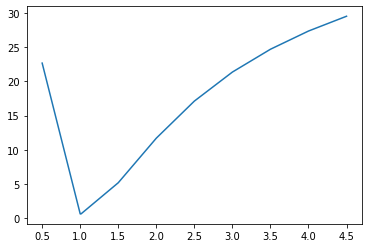

In [5]:
def test_errors_and_transfer(d):
    beta_s = beta_t + d * np.random.randn(p, 1)
    Y1 = X1 @ beta_s + sigma * np.random.randn(n1, 1)

    te_beta_t = te_target(X1, X2, beta_t, beta_t, 0)

    w_hat = opt_w_val(X1, X2, beta_s, beta_t, n1, n2)
    te_beta_st = te_target(X1, X2, beta_s, beta_t, w_hat)
    print('Test error:', 'STL', te_beta_t, 'MTL', te_beta_st, 'OPT_W', w_hat)

    if te_beta_st < te_beta_t:
        print('Positive transfer')
    else:
        print('Negative transfer')
        
    delta_beta = p * ((1 - w_hat)**2 + d**2) * c1**2 * (c1 + c2) / (c1 + c2 - 1)**3
    delta_var = sigma**2 * c1 / ((c2 - 1) * (c1 + c2 - 1))
    deviation_ub = (1 + math.sqrt(1/c1))**4
    deviation_lb = (1 - math.sqrt(1/c1))**4

    print(delta_var, delta_beta, delta_var / delta_beta)

    if delta_var / delta_beta >= deviation_ub:
        print('Provably positive')
    elif delta_var / delta_beta <= deviation_lb:
        print('Provably negative')

    print(deviation_lb, deviation_ub)
    
test_errors_and_transfer(0.1)

## Plot the effect of task distance

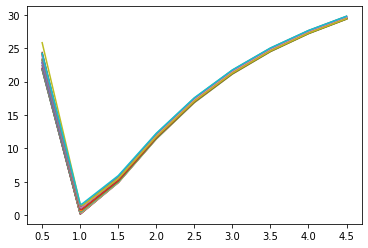

In [43]:
d_list = [0.01 * i for i in range(1, 21)]
te_mtl_list = []

delta_beta_base = p * c1**2 * (c1 + c2) / (c1 + c2 - 1)**3

provable_pos = [[], []]
provable_neg = [[], []]
unknown = [[], []]
#cos_sim_list = []

for d in d_list:
    beta_s = beta_t + d * np.random.randn(p, 1)
    #cosine_sim = abs(beta_s.T @ beta_t) / (np.linalg.norm(beta_s) * np.linalg.norm(beta_t))    
    Y1 = X1 @ beta_s + sigma * np.random.randn(n1, 1)

    #hat_beta_st = np.linalg.inv(X1.T @ X1 + X2.T @ X2) @ (X1.T @ Y1 + X2.T @ Y2)
    hat_w = opt_w_val(X1, X2, beta_s, beta_t, n1, n2)
    te_beta_st = te_target(X1, X2, beta_s, beta_t, hat_w)
    
    #te_beta_st = np.linalg.norm(test_X2 @ hat_beta_st - test_Y2) ** 2 / test_n2
    te_mtl_list.append(te_beta_st)
    
    delta_beta = ((1 - hat_w)**2 + d**2) * delta_beta_base    
    delta_var = sigma**2 * c1 / ((c2 - 1) * (c1 + c2 - 1))
    deviation_ub = (1 + math.sqrt(1/c1))**4
    deviation_lb = (1 - math.sqrt(1/c1))**4

    if delta_var / delta_beta > deviation_ub:
        provable_pos[0].append(d)
        provable_pos[1].append(te_beta_st)
    elif delta_var / delta_beta < deviation_lb:    
        provable_neg[0].append(d)
        provable_neg[1].append(te_beta_st)
    else:
        unknown[0].append(d)
        unknown[1].append(te_beta_st)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


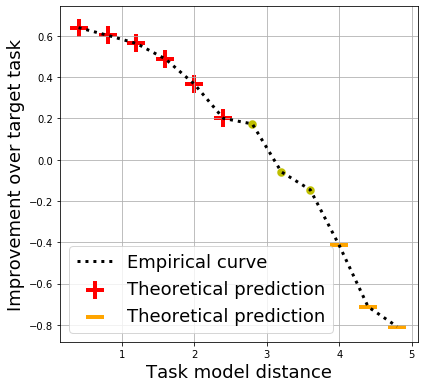

In [160]:
#cos_sim_list_inv = 1.0 - np.ndarray.flatten(np.array(cos_sim_list))

te_beta_t = te_target(X1, X2, beta_s, beta_t, 0)

plt.figure(figsize=(6,5.5))

x_thy_neg = 1000* np.array(provable_neg[0])/sigma**2
y_thy_neg = te_beta_t - np.array(provable_neg[1])
x_thy_neg = x_thy_neg[: len(x_thy_neg) - cut]
y_thy_neg = y_thy_neg[: len(y_thy_neg) - cut]
x_emp_curve = 1000* np.array(d_list)/sigma**2
x_emp_curve = x_emp_curve[: len(x_emp_curve) - cut]
y_emp_curve = te_beta_t - np.array(te_mtl_list)
y_emp_curve = y_emp_curve[: len(y_emp_curve) - cut]

cut = 8
plt.scatter(1000* np.array(provable_pos[0])/sigma**2, te_beta_t - np.array(provable_pos[1]), marker='+', s=300, lw=4, c='r', label='Theoretical prediction')
plt.scatter(x_thy_neg, y_thy_neg, marker='_', s=300, lw=4, c='orange', label='Theoretical prediction')
plt.scatter(1000* np.array(unknown[0])/sigma**2, te_beta_t - np.array(unknown[1]), marker='o', s=20, lw=4, c='y')
plt.plot(x_emp_curve, y_emp_curve, c='k', lw=3, ls=':', label='Empirical curve')
#plt.plot(np.arange(0.0, 0.22, 0.01), [te_beta_t] * 22, lw=3, c='k', ls='dotted', label='Single-task learning')


#plt.fill_between(np.arange(0.0, 0.22, 0.01), [te_beta_t] * 22, alpha=0.10, color='gray', hatch = '/')

#plt.xticks(np.arange(0, 7, 2), fontsize=14)
#plt.yticks(np.arange(-2, 2, 1), fontsize=14)
#plt.xlim([0,6])
plt.xlabel('Task model distance', fontsize=18)
plt.ylabel('Improvement over target task', fontsize=18)
plt.grid(0.4)
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig('model_shift_phase_transition.eps')

## Plot the effect of source task data size

In [40]:
#1.0 - np.ndarray.flatten(np.array(cos_sim_list))

array([5.66673251e-05, 1.85829889e-04, 4.14819186e-04, 7.04926322e-04,
       1.28040165e-03, 1.98443685e-03, 2.23706867e-03, 3.56059592e-03,
       3.65399617e-03, 5.25625561e-03, 6.12111247e-03, 7.41963810e-03,
       8.63502611e-03, 9.25071004e-03, 8.63164295e-03, 1.08262814e-02,
       1.43499833e-02, 1.43673779e-02, 1.59116849e-02, 2.10674578e-02])

In [89]:
te_beta_t - np.array(te_mtl_list)

array([ 0.63935444,  0.60229233,  0.56267023,  0.48761021,  0.36567804,
        0.20012438,  0.17334723, -0.05844826, -0.14546834, -0.41432934,
       -0.71237559, -0.80744404, -1.43884018, -1.45910967, -2.07842196,
       -2.45740333, -2.44964013, -2.85726528, -3.48386051, -3.80857312])

In [116]:
np.array(d_list)/sigma**2

array([0.0004, 0.0008, 0.0012, 0.0016, 0.002 , 0.0024, 0.0028, 0.0032,
       0.0036, 0.004 , 0.0044, 0.0048, 0.0052, 0.0056, 0.006 , 0.0064,
       0.0068, 0.0072, 0.0076, 0.008 ])

In [161]:
for a, b in zip(1000* np.array(provable_pos[0])/sigma**2, te_beta_t - np.array(provable_pos[1])):
    print(a, b)
print()

for a, b in zip(x_thy_neg, y_thy_neg):
    print(a, b)
print()

for a, b in zip(1000* np.array(unknown[0])/sigma**2, te_beta_t - np.array(unknown[1])):
    print(a, b)

0.4 0.6393544365009209
0.8 0.6022923339301798
1.2 0.5626702325854624
1.6 0.4876102133164526
2.0 0.36567804410710714
2.4 0.20012438473989402

4.0 -0.4143293385037451
4.4 -0.7123755906669883
4.8 -0.8074440377063316

2.8 0.17334723300771682
3.2 -0.05844826066038067
3.6 -0.14546833698595674


In [144]:
thy_neg = 1000* np.array(provable_neg[0])/sigma**2
print(thy_neg[:8])

[4.  4.4 4.8 5.2 5.6 6.  6.4 6.8]


In [149]:
emp_curve = 1000* np.array(d_list)/sigma**2
print(len(emp_curve), emp_curve[:17])

20 [0.4 0.8 1.2 1.6 2.  2.4 2.8 3.2 3.6 4.  4.4 4.8 5.2 5.6 6.  6.4 6.8]
